### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import os

%matplotlib inline

In [5]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

### Prepair Training Data

Data:- https://www.kaggle.com/c/dogs-vs-cats/data

In [6]:
filename = os.listdir('train')
category = []
for image_name in filename:
    name = image_name.split('.')[0]
    if name == 'cat': 
        category.append('cat')
    else: 
        category.append('Dog')
        
df = pd.DataFrame({'filename' : filename,
                   'category' : category})

In [7]:
df.category.value_counts()

cat    12500
Dog    12500
Name: category, dtype: int64

#### Lets See Sample Image

In [8]:
sample = np.random.choice(filename)

cat.2376.jpg


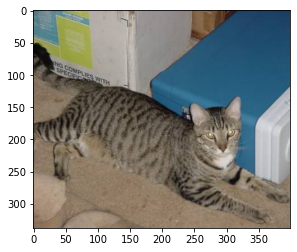

In [9]:
print(sample)
img = load_img("train/" + sample)
plt.imshow(img)
plt.show()

### Creating the Image Classification Model

<b>Batch normalization</b> (also known as batch norm) is a technique for improving the speed, performance, and stability of neural networks. It is used to normalize the input layer by re-centering and re-scaling.

<b>DropOut</b> is also used to decrease overfitting problem in neural networks To prevent overfitting, Overfitting is a modeling error that occurs to make an overly complex model. This layer drops out a random set of activations in that layer by setting them to zero as data flows through it..

<b>Max pooling</b> is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

<b>Activation</b> we will use <b>ReLU</b> activation function in hidden layers so that it returns 0 for every negative value in the input image while it returns the same value for every positive value and We need to apply a <b>Sigmoid</b> activation function in outer layer so that it will convert the data into probabilities for each class. A sigmoid function is a mathematical function having an S-shaped curve or sigmoid curve.

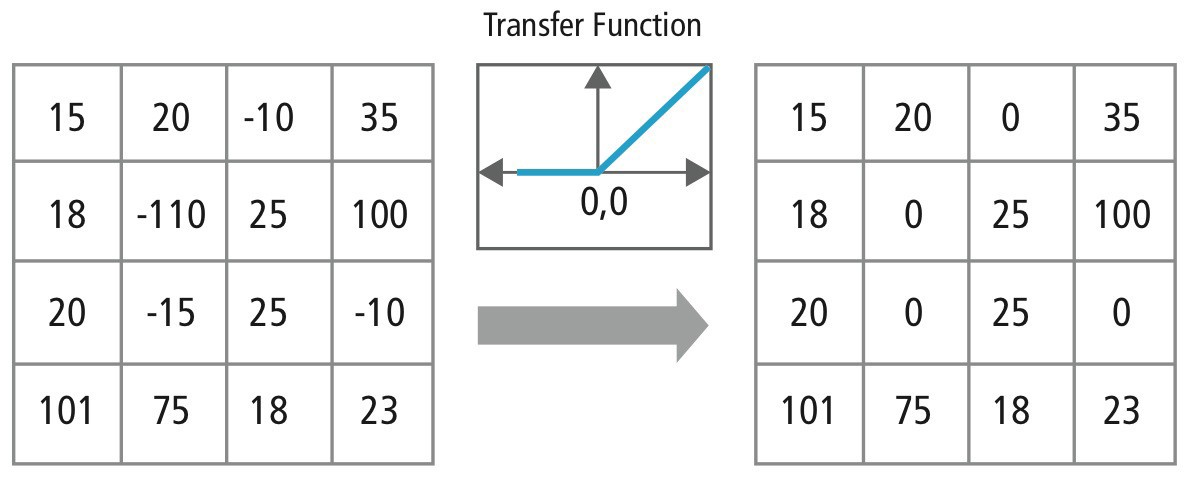

<b>Dense Layer</b> (fully connected layer) In a fully connected layer, we flatten the output of the last convolution layer and connect every node of the current layer with the other node of the next layer. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks and work in a similar way.

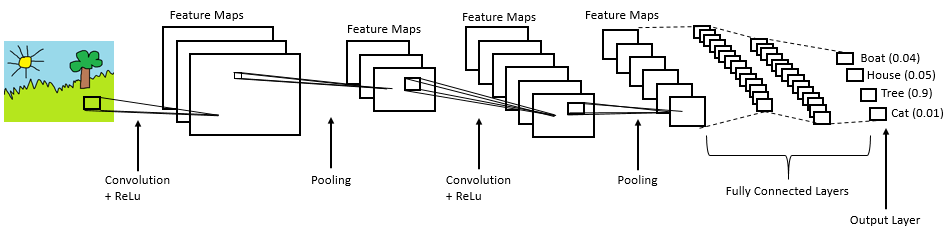

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3,3), activation = "relu", input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

### Early Stopping in Keras to Prevent Overfitting
<b>Overfitting</b> occurs when a neural network is trained to the point that it begins to memorize rather than generalize, as demonstrated in Figure 

<b>Training vs Validation Error for Overfitting</b>

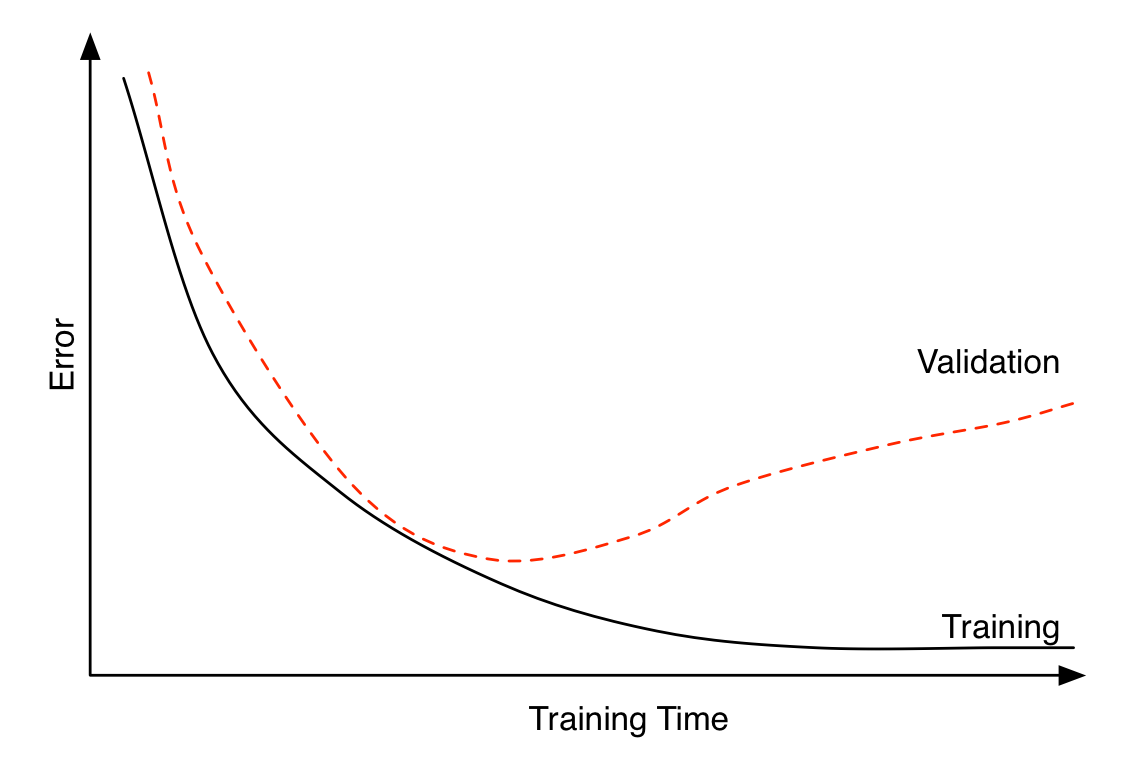

 It is important to segment the original dataset into several datasets:
- <b>Training Set</b>
- <b>Validation Set</b>
- <b>Holdout Set</b>

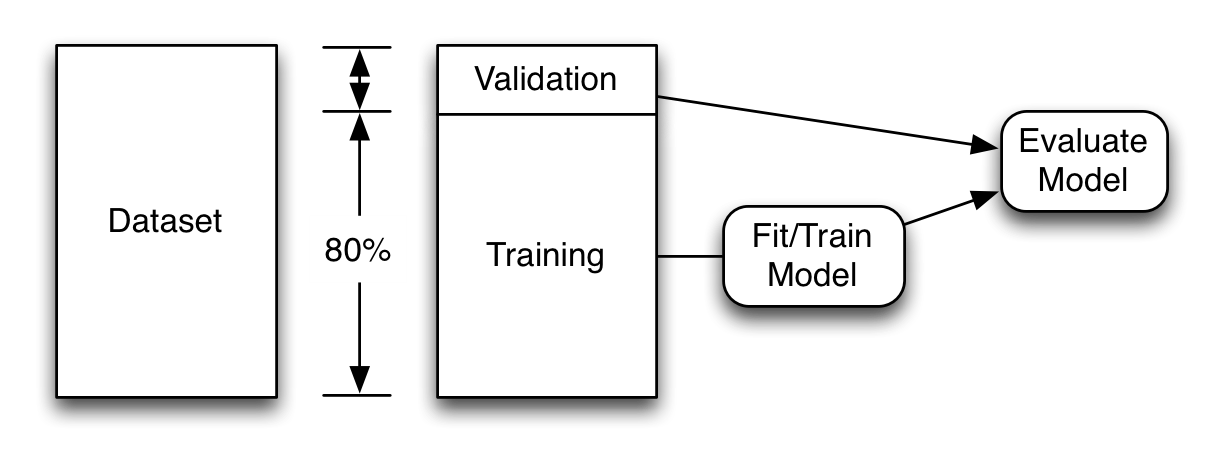

In [11]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, 
        verbose = 1, mode = 'auto', restore_best_weights = True)

#### Train Validation Split

In [13]:
train_df, valadition_df = train_test_split(df, test_size = 0.25, random_state = 567)

In [14]:
train_df.category.value_counts()

Dog    9400
cat    9350
Name: category, dtype: int64

In [15]:
valadition_df.category.value_counts()

cat    3150
Dog    3100
Name: category, dtype: int64

In [16]:
total_train_size = train_df.shape[0]
total_valadition_size = valadition_df.shape[0]
batch_size = 32

### Data Augmentation

Data augmentation is required before we train the model, so as to reduce overfitting. Data augmentation means increasing the number of images in the data set. So, we will flip, zoom and do a lot of things with all the existing data set images, so that the machine will get a variety of types of images to study.

Before we train the model, we need to set the train and test directories. Keras has a method called flow_from_dataframe() method. After we run this cell, the machine will say that it has found the images in our data set.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

#For training
train_generator = ImageDataGenerator(rotation_range = 25,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2,
                                     horizontal_flip = True,
                                     rescale = 1.0/255,
                                     shear_range = 0.2,
                                     fill_mode = 'nearest',
                                     zoom_range = 0.2)

train_gen = train_generator.flow_from_dataframe(train_df,
                                                "train", 
                                                x_col = 'filename', 
                                                y_col = 'category', 
                                                target_size = IMAGE_SIZE,
                                                batch_size = batch_size)

# for validation
validation_generator = ImageDataGenerator(rescale = 1.0/255)

validation_gen = validation_generator.flow_from_dataframe(valadition_df,
                                                "train", 
                                                x_col = 'filename', 
                                                y_col = 'category', 
                                                target_size = IMAGE_SIZE,
                                                batch_size = batch_size)

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [18]:
sample_df = train_df.sample(n = 1).reset_index(drop = True)
sample_generator = train_generator.flow_from_dataframe(sample_df,
                                                "train", 
                                                x_col = 'filename', 
                                                y_col = 'category', 
                                                target_size = IMAGE_SIZE,
                                                batch_size = batch_size)

Found 1 validated image filenames belonging to 1 classes.


#### Sample Generated Image Using Data Augmentation

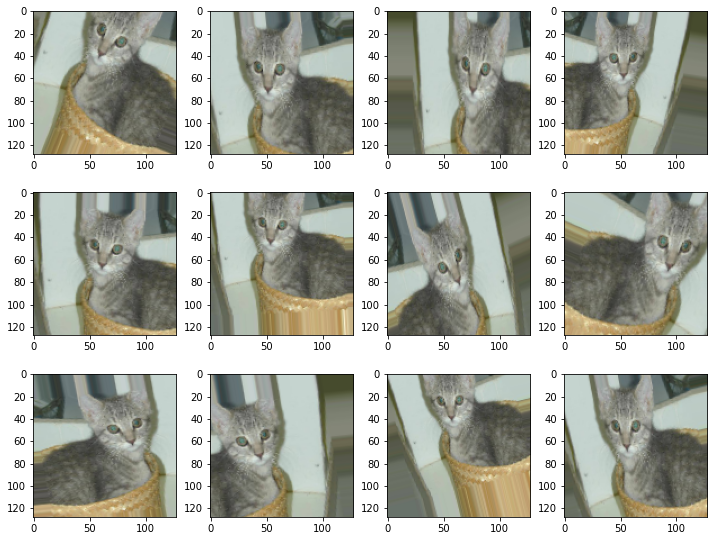

In [19]:
plt.figure(figsize = (10, 10))
for i in range(0, 12):
    plt.subplot(4, 4, i+1)
    for x, y in sample_generator:
        img = x[0]
        plt.imshow(img)
        break
plt.tight_layout()
plt.show()

### Fit Model

In [21]:
import time
a = time.time()

classifier = model.fit(train_gen, 
                       epochs = 100, 
                       validation_data = validation_gen, 
                       callbacks = [monitor])
print(time.time() - a)

Epoch 1/100
586/586 [==============================] - 1646s 3s/step - loss: 0.6797 - acc: 0.6131 - val_loss: 0.5708 - val_acc: 0.6530
Epoch 2/100
586/586 [==============================] - 1648s 3s/step - loss: 0.5961 - acc: 0.6818 - val_loss: 0.4763 - val_acc: 0.7398
Epoch 3/100
586/586 [==============================] - 1642s 3s/step - loss: 0.5516 - acc: 0.7157 - val_loss: 0.5772 - val_acc: 0.7322
Epoch 4/100
586/586 [==============================] - 1622s 3s/step - loss: 0.5206 - acc: 0.7392 - val_loss: 0.5995 - val_acc: 0.7645
Epoch 5/100
586/586 [==============================] - 1794s 3s/step - loss: 0.4896 - acc: 0.7619 - val_loss: 0.4290 - val_acc: 0.7200
Epoch 6/100
586/586 [==============================] - 1888s 3s/step - loss: 0.4686 - acc: 0.7767 - val_loss: 0.8576 - val_acc: 0.7125
Epoch 7/100
586/586 [==============================] - 1890s 3s/step - loss: 0.4393 - acc: 0.7931 - val_loss: 1.2250 - val_acc: 0.7875
Epoch 8/100
586/586 [==============================] - 

### Save Model

In [24]:
model.save_weights('model.h5')

### Testing the classifier

#### Prepare Test Data

In [188]:
test_filename = os.listdir('test1')
test_data = pd.DataFrame({'filename' : test_filename})

In [189]:
test_generator = ImageDataGenerator(rescale = 1.0/255)
test_gen = test_generator.flow_from_dataframe(test_data,
                                             'test1',
                                              x_col = 'filename',
                                              y_col = None,
                                              class_mode = None,
                                              target_size = IMAGE_SIZE,
                                              batch_size = batch_size,
                                              shuffle = False)

Found 12500 validated image filenames.


#### Prediction On Test Data 

In [190]:
predict = model.predict_generator(test_gen)

In [204]:
test_data['category'] = np.argmax(predict, axis = 1)

In [233]:
lable = dict((v,k) for k,v in train_gen.class_indices.items())
test_data['category'] = test_data['category'].replace(lable)

In [231]:
test_data['category'] = test_data['category'].replace({'Dog' : 1, 'cat' : 0})

In [234]:
cat_or_dog['category'] = cat_or_dog['category'].replace({1 : 'Dog', 0 : 'cat'})

### Lets See Preticted Result

In [251]:
test_sample = test_data[51:60]
name = cat_or_dog['category'][51:60].tolist()

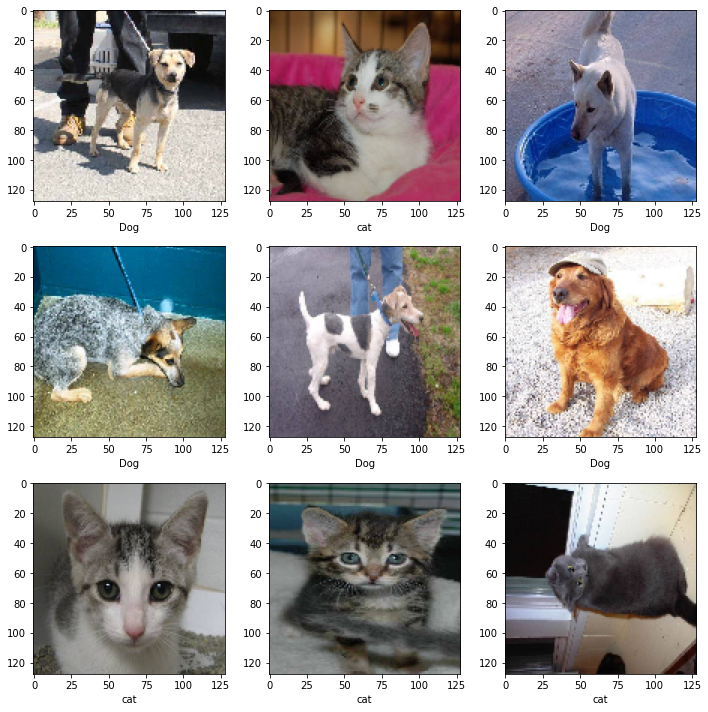

In [256]:
plt.figure(figsize = (10,10))
i = 0
j = -1
for index, row in test_sample.iterrows():
    i = 1 + i
    j = j + 1
    filename = row['filename']
    category = name[j]
    image = load_img('test1/'+filename, target_size = IMAGE_SIZE)
    
    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.xlabel("{}".format(category))
plt.tight_layout()
plt.show()

### Save Test Result

In [265]:
Submission_data = test_data.copy()
Submission_data['id'] = Submission_data['filename'].str.split('.').str[0]
Submission_data['lable'] = Submission_data['category']
Submission_data.drop(['filename', 'category'], inplace = True, axis = 1)
Submission_data.to_csv('Submission.csv', index = False)